<a href="https://colab.research.google.com/github/abuqaiselegant/BigData/blob/main/bigdata_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**End-to-end Spark pipeline: load and explore data, encode features, and apply class balancing via undersampling and multiple SMOTE-BD variants (standard, borderline, adaptive, exact)  
Result: a shuffled, balanced DataFrame with assembled feature vectors ready for model training**

Abu Qais, Harsh Moradiya, Muneeb Amer, Mohd Ali Tahir



Imports for data handling , visualization , model evaluation , class imbalance handling (SMOTENC), and ML pipeline construction with Spark (StringIndexer, VectorAssembler, GBTClassifier, Pipeline, BinaryClassificationEvaluator).


In [32]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report , roc_curve, auc
from time import time


from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, concat_ws, floor
from pyspark.sql.functions import spark_partition_id
#ML imports
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder

from pyspark.ml.evaluation import BinaryClassificationEvaluator


# Initialize a local SparkSession named "BD" and retrieve its SparkContext for distributed data processing.


In [3]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("BD") \
    .getOrCreate()

sc = spark.sparkContext

In [4]:
spark


# Load the CSV file 'diabetic_data.csv' into a Spark DataFrame named df.


In [5]:
df = spark.read.csv('/content/diabetic_data.csv')

In [6]:
df.show()

+------------+-----------+---------------+------+--------+------+-----------------+--------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+--------------------+--------------------+--------------------+------+-----------+----------+
|         _c0|        _c1|            _c2|   _c3|     _c4|   _c5|              _c6|                 _c7|                _c8|             _c9|      _c10|                _c11|              _c12|          _c13|           _c14|             _c15|            _c16|            _c17|  _c18|  _c19|  _c20|            _c21|         _c2

# **Section 1: Preprocessing**

# EDA: load data with header and inferred schema into Spark, rename ‘encounter_id’ to ‘id’, inspect schema and dataset dimensions, and analyze unique and missing values with sample distinct entries


Assigned Member: Abu Qais and Mohd Ali Tahir



In [7]:
df =spark.read.option('header','true').csv('/content/diabetic_data.csv')
df.show(truncate=False)
df.count()

+------------+-----------+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+------------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|race           |gender|age     |weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty       |num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|numb

101766

In [8]:
type(df)

pyspark.sql.dataframe.DataFrame

In [ ]:
df.columns

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted']

In [ ]:
df.printSchema()

root
 |-- encounter_id: string (nullable = true)
 |-- patient_nbr: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: string (nullable = true)
 |-- discharge_disposition_id: string (nullable = true)
 |-- admission_source_id: string (nullable = true)
 |-- time_in_hospital: string (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: string (nullable = true)
 |-- num_procedures: string (nullable = true)
 |-- num_medications: string (nullable = true)
 |-- number_outpatient: string (nullable = true)
 |-- number_emergency: string (nullable = true)
 |-- number_inpatient: string (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: string (nullable = true)
 |-- max_glu_ser

**using inferschema to detectsome columns to Integers**

In [9]:
df =spark.read.option('header','true').csv('/content/diabetic_data.csv',inferSchema = True)
df.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-

In [ ]:
df.head(1)

[Row(encounter_id=2278392, patient_nbr=8222157, race='Caucasian', gender='Female', age='[0-10)', weight='?', admission_type_id=6, discharge_disposition_id=25, admission_source_id=1, time_in_hospital=1, payer_code='?', medical_specialty='Pediatrics-Endocrinology', num_lab_procedures=41, num_procedures=0, num_medications=1, number_outpatient=0, number_emergency=0, number_inpatient=0, diag_1='250.83', diag_2='?', diag_3='?', number_diagnoses=1, max_glu_serum='None', A1Cresult='None', metformin='No', repaglinide='No', nateglinide='No', chlorpropamide='No', glimepiride='No', acetohexamide='No', glipizide='No', glyburide='No', tolbutamide='No', pioglitazone='No', rosiglitazone='No', acarbose='No', miglitol='No', troglitazone='No', tolazamide='No', examide='No', citoglipton='No', insulin='No', glyburide-metformin='No', glipizide-metformin='No', glimepiride-pioglitazone='No', metformin-rosiglitazone='No', metformin-pioglitazone='No', change='No', diabetesMed='No', readmitted='NO')]

In [ ]:
df.dtypes

[('encounter_id', 'int'),
 ('patient_nbr', 'int'),
 ('race', 'string'),
 ('gender', 'string'),
 ('age', 'string'),
 ('weight', 'string'),
 ('admission_type_id', 'int'),
 ('discharge_disposition_id', 'int'),
 ('admission_source_id', 'int'),
 ('time_in_hospital', 'int'),
 ('payer_code', 'string'),
 ('medical_specialty', 'string'),
 ('num_lab_procedures', 'int'),
 ('num_procedures', 'int'),
 ('num_medications', 'int'),
 ('number_outpatient', 'int'),
 ('number_emergency', 'int'),
 ('number_inpatient', 'int'),
 ('diag_1', 'string'),
 ('diag_2', 'string'),
 ('diag_3', 'string'),
 ('number_diagnoses', 'int'),
 ('max_glu_serum', 'string'),
 ('A1Cresult', 'string'),
 ('metformin', 'string'),
 ('repaglinide', 'string'),
 ('nateglinide', 'string'),
 ('chlorpropamide', 'string'),
 ('glimepiride', 'string'),
 ('acetohexamide', 'string'),
 ('glipizide', 'string'),
 ('glyburide', 'string'),
 ('tolbutamide', 'string'),
 ('pioglitazone', 'string'),
 ('rosiglitazone', 'string'),
 ('acarbose', 'string'),

In [10]:
df = df.withColumnRenamed('encounter_id','id') #renamed the encounter id column
df.show()

+-------+-----------+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|     id|patient_nbr|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_g

In [ ]:
row_count = df.count()
row_count

101766

In [ ]:
col_count =len(df.columns)
col_count

50

**Counting null values and '?'**
Many missing values in this dataset are represented by "?" instead of actual nulls.

This line counts how many missing or "?" entries exist per column.


In [11]:
from pyspark.sql.functions import col, when, count
columns = df.columns
null_counts = df.select([count(when(col(c).isNull() | (col(c)=='?'),c)).alias(c) for c in columns])

In [ ]:
null_counts.show()

+---+-----------+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
| id|patient_nbr|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateg

**Unique values of each Column** this is important as smotenc or may be different sampling techniques doesnot handle more unique values well
This tells you which columns are categorical (low unique count) vs. possibly high-cardinality (many distinct values).

Helps in feature selection and deciding which features need encoding or grouping.

In [ ]:
for col_name in columns:
    unique_count = df.select(col_name).distinct().count()
    print(f"{col_name}: {unique_count} unique values")

id: 101766 unique values
patient_nbr: 71518 unique values
race: 6 unique values
gender: 3 unique values
age: 10 unique values
weight: 10 unique values
admission_type_id: 8 unique values
discharge_disposition_id: 26 unique values
admission_source_id: 17 unique values
time_in_hospital: 14 unique values
payer_code: 18 unique values
medical_specialty: 73 unique values
num_lab_procedures: 118 unique values
num_procedures: 7 unique values
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient: 21 unique values
diag_1: 717 unique values
diag_2: 749 unique values
diag_3: 790 unique values
number_diagnoses: 16 unique values
max_glu_serum: 4 unique values
A1Cresult: 4 unique values
metformin: 4 unique values
repaglinide: 4 unique values
nateglinide: 4 unique values
chlorpropamide: 4 unique values
glimepiride: 4 unique values
acetohexamide: 2 unique values
glipizide: 4 unique values
glyburide: 4 unique values
tolbutamide: 2 unique

In [12]:
#will refine for the columns i need
print("\nSample Unique Values (Top 5):")
for col_name in columns:
    print(f"{col_name}:")
    df.select(col_name).distinct().show(5, truncate=False)


Sample Unique Values (Top 5):
id:
+-------+
|id     |
+-------+
|325848 |
|1069716|
|2569794|
|2577756|
|4255566|
+-------+
only showing top 5 rows

patient_nbr:
+-----------+
|patient_nbr|
+-----------+
|2038905    |
|6550191    |
|300825     |
|2766582    |
|12254760   |
+-----------+
only showing top 5 rows

race:
+---------------+
|race           |
+---------------+
|Caucasian      |
|Other          |
|AfricanAmerican|
|Hispanic       |
|Asian          |
+---------------+
only showing top 5 rows

gender:
+---------------+
|gender         |
+---------------+
|Female         |
|Unknown/Invalid|
|Male           |
+---------------+

age:
+--------+
|age     |
+--------+
|[70-80) |
|[90-100)|
|[40-50) |
|[10-20) |
|[20-30) |
+--------+
only showing top 5 rows

weight:
+---------+
|weight   |
+---------+
|[150-175)|
|[125-150)|
|[0-25)   |
|[25-50)  |
|[75-100) |
+---------+
only showing top 5 rows

admission_type_id:
+-----------------+
|admission_type_id|
+-----------------+
|1       

**Replacing "?" with null**

In [13]:
df_clean = df.replace('?',None)

In [14]:
df_clean = df_clean.dropna(subset=['readmitted'])
df_clean = df_clean.fillna({'race': 'Unknown', 'gender': 'Unknown', 'diag_1': 'Unknown', 'diag_2': 'Unknown', 'diag_3': 'Unknown'})
print(f"Cleaned—now {df_clean.count()} rows!")

Cleaned—now 101766 rows!


In [15]:
df_clean.show()

+-------+-----------+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+-------+-------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|     id|patient_nbr|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1| diag_2| diag_3|number_diagnoses|m

We're throwing out any rows where the final answer (readmitted) is missing.

Then, if anything important like gender or race is blank, we’re just writing 'Unknown' there.

Finally, we check how many good rows we still have left.

picking out all the patients who came back to the hospital in less than 30 days, and  printing how many there are.

In [16]:
readmitted_30 =df_clean.filter(df_clean.readmitted=='<30')
print(f"Patients readmitted <30 days {readmitted_30.count()}")

Patients readmitted <30 days 11357


In [17]:
print("Null Counts:")
null_counts.show()

Null Counts:
+---+-----------+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
| id|patient_nbr|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repa

In [18]:
df_clean.groupBy('readmitted').count().show()

+----------+-----+
|readmitted|count|
+----------+-----+
|       >30|35545|
|        NO|54864|
|       <30|11357|
+----------+-----+



In [19]:
df_clean = df_clean.fillna({'race': 'Unknown', 'diag_1': 'Unknown', 'diag_2': 'Unknown', 'diag_3': 'Unknown'})

df_clean.show()

+-------+-----------+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+-------+-------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|     id|patient_nbr|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1| diag_2| diag_3|number_diagnoses|m

**Till here except weight, player code, medical speciality all are cleaned**


Go through each column and count how many values are missing (null). Then show the table with those numbers

In [20]:
null_counts = df_clean.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns])
# Show the null counts
print("Null Counts:")
null_counts.show()

Null Counts:
+---+-----------+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
| id|patient_nbr|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repa

**dropping some no used column**


In [21]:
columns_to_drop = [
    'weight', 'payer_code', 'medical_specialty',
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id'
]
df_clean = df_clean.drop(*columns_to_drop)
print(f"Dropped columns: {columns_to_drop}")
print(f"Remaining columns: {len(df_clean.columns)} ({df_clean.columns})")

Dropped columns: ['weight', 'payer_code', 'medical_specialty', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
Remaining columns: 44 (['id', 'patient_nbr', 'race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'])


**adding target column with less than 30 value to 1 and oters are 0**

making a new column called target.
If the patient came back to the hospital in under 30 days,  write 1.
Otherwise, write 0.
This new column is what model will try to predict, key step for ML

In [22]:
df_clean = df_clean.withColumn(
    'target',
    when(col('readmitted') == '<30', 1).otherwise(0))

In [23]:
df_clean.show()

+-------+-----------+---------------+------+--------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+-------+-------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+------+
|     id|patient_nbr|           race|gender|     age|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1| diag_2| diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|glimepiride|acetohexamide|glipizide|glyburide|tolbutamide|pioglitazone|rosiglitazone|acarbose|miglitol|troglitazone|tolazamid

**diag_1, diag_2, diag_3 are now grouped in 3 new columns with data description given with dataset**

The diagnosis columns have messy medical codes.
Grouped them into simple categories like ‘Diabetes’ or ‘Heart Problems’.
Did this for the first 3 diagnosis columns and added new ones that are easier for the model to understand.

In [24]:
def map_diagnosis(diag_col):
    return when(col(diag_col).isNull(), 'Unknown') \
        .when(col(diag_col).cast('string').between('390', '459') | (col(diag_col) == '785'), 'Circulatory') \
        .when(col(diag_col).cast('string').between('460', '519') | (col(diag_col) == '786'), 'Respiratory') \
        .when(col(diag_col).cast('string').between('520', '579') | (col(diag_col) == '787'), 'Digestive') \
        .when(col(diag_col).cast('string').startswith('250'), 'Diabetes') \
        .when(col(diag_col).cast('string').between('800', '999'), 'Injury') \
        .when(col(diag_col).cast('string').between('710', '739'), 'Musculoskeletal') \
        .when(col(diag_col).cast('string').between('580', '629') | (col(diag_col) == '788'), 'Genitourinary') \
        .when(col(diag_col).cast('string').between('140', '239'), 'Neoplasms') \
        .when((col(diag_col).cast('string').between('780', '781')) | (col(diag_col).cast('string').between('784', '799')), 'Other Symptoms') \
        .when(col(diag_col).cast('string').between('240', '279') & ~col(diag_col).cast('string').startswith('250'), 'Endocrine') \
        .when(col(diag_col).cast('string').between('680', '709') | (col(diag_col) == '782'), 'Skin') \
        .when(col(diag_col).cast('string').between('001', '139'), 'Infectious') \
        .when(col(diag_col).cast('string').between('290', '319'), 'Mental') \
        .when(col(diag_col).cast('string').startswith('E') | col(diag_col).cast('string').startswith('V'), 'External') \
        .when(col(diag_col).cast('string').between('280', '289'), 'Blood') \
        .when(col(diag_col).cast('string').between('320', '359'), 'Nervous') \
        .when(col(diag_col).cast('string').between('630', '679'), 'Pregnancy') \
        .when(col(diag_col).cast('string').between('360', '389'), 'Sense Organs') \
        .when(col(diag_col).cast('string').between('740', '759'), 'Congenital') \
        .otherwise('Other')

#these 3 column are added (these are categorical)
df_clean = df_clean.withColumn('diag_1_grouped', map_diagnosis('diag_1')) \
                   .withColumn('diag_2_grouped', map_diagnosis('diag_2')) \
                   .withColumn('diag_3_grouped', map_diagnosis('diag_3'))

Drop diag columns

In [25]:
diag_cols = ['diag_1','diag_2','diag_3']
df_clean = df_clean.drop(*diag_cols)

In [26]:
df_clean.show()

+-------+-----------+---------------+------+--------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+------+---------------+--------------+---------------+
|     id|patient_nbr|           race|gender|     age|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|glimepiride|acetohexamide|glipizide|glyburide|tolbutamide|pioglitazone|rosiglitazone|acarbose|miglitol|troglitazone|tolazami

made a list of all the columns and want to use — including patient info, diagnosis groups, medications, and hospital stats.

Have also marked which of those are categories like gender, race, and drug names.
Then created a new DataFrame that keeps only these useful columns, ready for machine learning

In [36]:
medication_cols = [
    'metformin','max_glu_serum','A1Cresult','repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
]
features = [
    'race', 'gender', 'age',  # Core categoricals
    'diag_1_grouped', 'diag_2_grouped', 'diag_3_grouped',  # Grouped diagnoses
    'change','diabetesMed'
] + medication_cols + [  # All medications
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',  # Numericals
    'target'  # Target
]

categorical_columns = ['race', 'gender', 'age',  # Core categoricals
    'diag_1_grouped', 'diag_2_grouped', 'diag_3_grouped',  # Grouped diagnoses
    'change','diabetesMed']+medication_cols


# Step 3: Vector Assembling
numerical_cols = [
    "time_in_hospital", "num_lab_procedures", "num_procedures",
    "num_medications", "number_outpatient", "number_emergency",
    "number_inpatient", "number_diagnoses"
]


df_final = df_clean.select(features)
#df_final.show()

In [28]:
# All columns except 'target'
feature_cols = [col for col in df_final.columns if col != 'target']

# Categorical indices
cat_indices = [feature_cols.index(col) for col in categorical_columns]

In [29]:
# Features (X) and target (y)
X = df_final[feature_cols] #can also used features
y = df_final['target']

In [30]:
df_final.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|     1|11357|
|     0|90409|
+------+-----+



# Section 2: Sampling


**Undersampling - 2 methods**

Assignemd Member: Abu Qais and Mohd Ali Tahir

**Random sampling**

random undersample to balance classes, apply StringIndexer and OneHotEncoder to categorical columns, and assemble all features into a single vector


In [33]:
from pyspark.sql.functions import rand
# Step 1: Random Undersampling
minority_df = df_final.filter("target = 1")
majority_df = df_final.filter("target = 0")

minority_count = minority_df.count()
sampling_fraction = float(minority_count) / majority_df.count()
majority_sampled_df = majority_df.sample(withReplacement=False, fraction=sampling_fraction, seed=42)

balanced_df = minority_df.union(majority_sampled_df).orderBy(rand())

indexers = [StringIndexer(inputCol=col, outputCol=col + "_idx", handleInvalid='keep') for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=col + "_idx", outputCol=col + "_ohe") for col in categorical_columns]


# Step 3: Vector Assembling
numeric_cols = [
    "time_in_hospital", "num_lab_procedures", "num_procedures",
    "num_medications", "number_outpatient", "number_emergency",
    "number_inpatient", "number_diagnoses"
]

input_features = [col + "_ohe" for col in categorical_columns] + numeric_cols
assembler = VectorAssembler(inputCols=input_features, outputCol="features")



**Stratified Sampling**

processed stratified undersample majority class by age, index and one-hot encode categorical columns, and assemble all features into a single feature vector


In [34]:
from pyspark.sql.functions import rand
# this one is stratified sampling
minority_df = df_final.filter("target = 1")
majority_df = df_final.filter("target = 0")

minority_count = minority_df.count()
majority_count = majority_df.count()
sampling_fraction = float(minority_count) / majority_count

# 3. Build a fraction map for each age group
ages = [row.age for row in majority_df.select("age").distinct().collect()]
fractions = {age: sampling_fraction for age in ages}

majority_stratified_df = majority_df.stat.sampleBy("age",fractions, seed=13)

balanced_df = minority_df.union(majority_stratified_df)

indexers = [StringIndexer(inputCol=col, outputCol=col + "_idx", handleInvalid='keep') for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=col + "_idx", outputCol=col + "_ohe") for col in categorical_columns]


# Step 3: Vector Assembling
numeric_cols = [
    "time_in_hospital", "num_lab_procedures", "num_procedures",
    "num_medications", "number_outpatient", "number_emergency",
    "number_inpatient", "number_diagnoses"
]


input_features = [col + "_ohe" for col in categorical_columns] + numeric_cols
assembler = VectorAssembler(inputCols=input_features, outputCol="features")


# **Oversampling**

Assigned Member : Abu Qais, Harsh Moradiya, Muneeb Amer

SMOTENC:
The dataset had way fewer examples of patients readmitted in <30 days.
SMOTENC creates new, fake-but-realistic rows for those rare cases —
using the existing data as a guide.
Now  data has a fair balance between the two classes — ready for training

In [ ]:

smotenc = SMOTENC(categorical_features=cat_indices, random_state=1)
X_res, y_res = smotenc.fit_resample(X, y)

# Step 6: Check class distribution after SMOTENC
print("\nClass distribution after SMOTENC:")
print(pd.Series(y_res).value_counts())

# resampled dataframe
df_balanced = pd.DataFrame(X_res, columns=X.columns)
df_balanced["target"] = y_res

In [ ]:
#convert to spark df
df_balanced_spark = spark.createDataFrame(df_balanced)

In [ ]:
df_balanced_spark.groupBy("target").count().orderBy("target").show()
df_balanced_spark.show()

**Smote BD**

SMOTE-BD: custom partition-based generation of synthetic minority samples via numeric interpolation and categorical sampling, then merge with original data and shuffle for balanced classes

Logic: compute distances to all training samples, select the k nearest neighbors, and predict the label by majority vote of those neighbors

Assigned member: Abu Qais, Harsh Moradiya

In [37]:
# Step 1: Extract minority class samples
minority_df = df_final.filter("target = 1").select(features)  # features = numeric_cols + categorical_columns
print(f"Minority class count: {minority_df.count()}")

# Step 2: Define schema
from pyspark.sql.types import StructType, StructField, DoubleType, StringType
from pyspark.sql.functions import lit

schema = StructType(
    [StructField(col, DoubleType(), True) for col in numeric_cols] +
    [StructField(col, StringType(), True) for col in categorical_columns]
)

# Step 3: Define SMOTE-BD function
def smote_partition_categorical(iterator, k=3, N=2):
    from sklearn.neighbors import NearestNeighbors
    import numpy as np
    import random

    data = list(iterator)
    cleaned_data = []

    for row in data:
        try:
            numeric_part = [float(row[col]) if row[col] is not None else 0.0 for col in numeric_cols]
            categorical_part = [str(row[col]) if row[col] is not None else "" for col in categorical_columns]
            cleaned_data.append((numeric_part, categorical_part))
        except:
            continue

    if len(cleaned_data) <= k:
        return []

    X_num = np.array([row[0] for row in cleaned_data])
    X_cat = [row[1] for row in cleaned_data]

    try:
        nn = NearestNeighbors(n_neighbors=k+1).fit(X_num)
        neighbors = nn.kneighbors(X_num, return_distance=False)
    except:
        return []

    synthetic = []
    for i in range(len(X_num)):
        for _ in range(N):
            try:
                nn_index = random.choice(neighbors[i][1:])  # Exclude self
                gap = random.random()
                synth_num = X_num[i] + gap * (X_num[nn_index] - X_num[i])
                base_cat = X_cat[i]
                neighbor_cat = X_cat[nn_index]
                synth_cat = [
                    random.choice([base_cat[j], neighbor_cat[j]]) for j in range(len(base_cat))
                ]

                #  Fix: convert numpy float64 to native Python float
                synth_num_py = [float(x.item()) if hasattr(x, 'item') else float(x) for x in synth_num]
                full_row = tuple(synth_num_py) + tuple(synth_cat)

                synthetic.append(full_row)
            except:
                continue

    return synthetic

# Step 4: Apply SMOTE in partitions

synthetic_rdd = minority_df.rdd.mapPartitions(lambda part: smote_partition_categorical(part, k=3, N=4))

# Step 5: Create DataFrame from synthetic samples
synthetic_df = spark.createDataFrame(synthetic_rdd, schema=schema).withColumn("target", lit(1))

print(f"Synthetic sample count: {synthetic_df.count()}")

# Step 7: Combine original and synthetic data
final_df = df_final.unionByName(synthetic_df)

# Optional: Shuffle final data
from pyspark.sql.functions import rand
df_final_smotebd = final_df.orderBy(rand())

# Optional: Check final class balance
df_final_smotebd.groupBy("target").count().show()


Minority class count: 11357
Synthetic sample count: 45428
+------+-----+
|target|count|
+------+-----+
|     1|56785|
|     0|90409|
+------+-----+



In [ ]:
df_final_smotebd.count()

**Smote bd Borderline**

Borderline SMOTE-BD: broadcast full dataset, use k-NN to find minority samples near class boundary, generate synthetic examples by interpolating with minority neighbors, and union with original data

Differences: Borderline-SMOTE-BD only augments minority examples that lie near the class boundary (i.e., those with many majority-class neighbors), focusing on hard-to-classify regions.

Asiigned Member: Abu Qais, Muneeb Amer



In [38]:
global_rdd = df_final.select(numerical_cols + categorical_columns + ["target"]) \
               .rdd.map(lambda r: (
                     [float(r[col]) for col in numerical_cols],         # numeric features
                     [r[col]       for col in categorical_columns],        # categorical features
                     int(r["target"])                                   # class label
               ))

global_data = global_rdd.collect()
X_num_global = [nd for nd, cd, lab in global_data]
X_cat_global = [cd for nd, cd, lab in global_data]
Y_global     = [lab for nd, cd, lab in global_data]

# 4.2 Broadcast to all executors
bc_X_num = spark.sparkContext.broadcast(X_num_global)
bc_X_cat = spark.sparkContext.broadcast(X_cat_global)
bc_Y     = spark.sparkContext.broadcast(Y_global)

# 5. Borderline-SMOTE-BD function with Python casting
def smote_bd_borderline_partition(iterator, k=5, N=2):
    import numpy as np
    from sklearn.neighbors import NearestNeighbors
    import random

    X_all = bc_X_num.value
    Y_all = bc_Y.value
    nn_model = NearestNeighbors(n_neighbors=k+1).fit(np.array(X_all))

    synthetic = []
    for num_feat, cat_feat in iterator:
        # all num_feat entries are already Python floats
        neigh_idxs = nn_model.kneighbors([num_feat], return_distance=False)[0][1:]
        maj_count = sum(1 for idx in neigh_idxs if Y_all[idx] == 0)

        if maj_count > k // 2:
            # only minority neighbors
            min_neighs = [idx for idx in neigh_idxs if Y_all[idx] == 1]
            if not min_neighs:
                continue

            for _ in range(N):
                nbr = random.choice(min_neighs)
                neighbor_num = X_all[nbr]
                gap = random.random()

                # interpolate numerics, casting each to Python float
                synth_num = [
                    float(num_feat[i] + gap * (neighbor_num[i] - num_feat[i]))
                    for i in range(len(num_feat))
                ]
                # pick categories
                neighbor_cat = bc_X_cat.value[nbr]
                synth_cat = [
                    random.choice([cat_feat[i], neighbor_cat[i]])
                    for i in range(len(cat_feat))
                ]

                synthetic.append(tuple(synth_num) + tuple(synth_cat))

    return synthetic

# 6.1 Extract only minority rows (target == 1) with numeric + categorical
minority_rdd = df_final.filter("target = 1") \
    .select(numerical_cols + categorical_columns) \
    .rdd \
    .map(lambda r: (
        [float(r[c]) for c in numerical_cols],
        [r[c]       for c in categorical_columns]
    ))


# 6.2 Repartition for parallelism
# minority_parted = minority_rdd.repartition(4)

# 6.3 MapPartitions to generate synthetic samples
synthetic_rdd = minority_rdd.mapPartitions(
    lambda part: smote_bd_borderline_partition(part, k=3, N=8)
)
# 7.1 Define the schema
schema = StructType(
    [StructField(c, DoubleType(), True) for c in numerical_cols] +
    [StructField(c, StringType(), True) for c in categorical_columns]
)
# 7.2 Build DataFrame
synthetic_df = spark.createDataFrame(synthetic_rdd, schema=schema)

# 7.3 Add the 'target' column = 1 for all synthetic rows
from pyspark.sql.functions import lit
synthetic_df = synthetic_df.withColumn("target", lit(1))

# 8.1 Union
df_final_smotebd_borderline = df_final.unionByName(synthetic_df)
# (Optional) Shuffle if you like
df_fianl_smotebd_borderline = df_final_smotebd_borderline.orderBy(rand())
# 8.2 Check balance
df_final_smotebd_borderline.groupBy("target").count().show()


+------+-----+
|target|count|
+------+-----+
|     1|40485|
|     0|90409|
+------+-----+



**Adaptive Borderline Smote BD**

Adaptive Borderline-SMOTE-BD: broadcast global KNN model and data, adaptively generate synthetic minority samples based on neighbor majority ratio via numeric interpolation and categorical sampling, then merge and shuffle.

Adaptive Borderline-SMOTE-BD scales the number of synthetic samples per instance based on its local majority-neighbor ratio, producing more examples for harder (more imbalanced) cases.

 Maths logic:
 For each boundary minority instance:

   r    = maj_count / k

   N_i  = max(1, round(N * r))

   repeat N_i times:

     • u      ~ Uniform(0,1)
     • x_syn  = x_i + u * (x_nb - x_i)
     • for each categorical feature c_syn = random choice of {c_i, c_nb}


Assigned  Members: Abu Qais, Muneeb Amer

In [39]:

from pyspark.sql.types import StructType, StructField, DoubleType, StringType
from pyspark.sql.functions import lit, rand

# 1. Collect global data
global_rdd = df_final.select(numerical_cols + categorical_columns + ["target"]) \
    .rdd.map(lambda r: (
        [float(r[col]) for col in numerical_cols],
        [r[col]       for col in categorical_columns],
        int(r["target"])
    ))

global_data = global_rdd.collect()
X_num_global = [nd for nd, cd, lab in global_data]
X_cat_global = [cd for nd, cd, lab in global_data]
Y_global     = [lab for nd, cd, lab in global_data]

# 2. Broadcast raw arrays (for categories & labels)
bc_X_cat = spark.sparkContext.broadcast(X_cat_global)
bc_Y     = spark.sparkContext.broadcast(Y_global)

# 3. Train NearestNeighbors once on driver and broadcast the fitted model
import numpy as np
from sklearn.neighbors import NearestNeighbors

_driver_nn = NearestNeighbors(n_neighbors=3+1).fit(np.array(X_num_global))
bc_nn_model = spark.sparkContext.broadcast(_driver_nn)

# 4. Adaptive Borderline-SMOTE-BD partition function
def adaptive_smote_bd_borderline_partition(iterator, k=3, N=8):
    import random

    # retrieve broadcasts
    X_all   = bc_nn_model.value._fit_X       # training numerics stored inside the model
    Y_all   = bc_Y.value
    nn_model = bc_nn_model.value             # already-fitted model

    synth = []
    for num_feat, cat_feat in iterator:
        neigh_idxs = nn_model.kneighbors([num_feat], return_distance=False)[0][1:]
        maj_count  = sum(1 for idx in neigh_idxs if Y_all[idx] == 0)

        if maj_count > k // 2:
            ratio = maj_count / float(k)
            Ni    = max(1, int(round(N * ratio)))

            min_neighs = [idx for idx in neigh_idxs if Y_all[idx] == 1]
            if not min_neighs:
                continue

            for _ in range(Ni):
                nbr         = random.choice(min_neighs)
                neighbor_num = X_all[nbr]
                gap          = random.random()

                # interpolate numerics
                synth_num = [
                    float(num_feat[i] + gap * (neighbor_num[i] - num_feat[i]))
                    for i in range(len(num_feat))
                ]
                # choose categoricals
                neighbor_cat = bc_X_cat.value[nbr]
                synth_cat    = [
                    random.choice([cat_feat[i], neighbor_cat[i]])
                    for i in range(len(cat_feat))
                ]

                synth.append(tuple(synth_num) + tuple(synth_cat))

    return synth

# 5. Extract minority RDD
minority_rdd = (
    df_final
    .filter("target = 1")
    .select(numerical_cols + categorical_columns)
    .rdd
    .map(lambda r: (
        [float(r[c]) for c in numerical_cols],
        [r[c]       for c in categorical_columns]
    ))
)

# 6. Generate synthetic samples (no repartition)
synthetic_rdd = minority_rdd.mapPartitions(
    lambda part: adaptive_smote_bd_borderline_partition(part, k=3, N=16)
)

# 7. Build synthetic DataFrame
schema = StructType(
    [StructField(c, DoubleType(), True) for c in numerical_cols] +
    [StructField(c, StringType(), True) for c in categorical_columns]
)
synthetic_df = (
    spark.createDataFrame(synthetic_rdd, schema=schema)
         .withColumn("target", lit(1))
)

# 8. Union and shuffle
df_final_smotebd_borderline_tuned = (
    df_final.unionByName(synthetic_df)
            .orderBy(rand())
)

# 9. Check balance
df_final_smotebd_borderline_tuned.groupBy("target").count().show()


+------+-----+
|target|count|
+------+-----+
|     1|51408|
|     0|90409|
+------+-----+



**Exact Borderline SMOTE BD**

 calculate total synthetic samples to equalize classes, assign base and leftover counts per minority row, generate each via KNN interpolation with categorical sampling, then union and shuffle the final balanced dataset.

 Assigned Member: Abu Qais, Muneeb Amer, Mohd Ali Tahir

In [ ]:
counts    = df_final.groupBy("target").count().collect()
count_map = {row["target"]: row["count"] for row in counts}
maj_count = count_map.get(0, 0)
min_count = count_map.get(1, 0)

print(f"Majority = {maj_count:,}, Minority = {min_count:,}")
total_needed = max(0, maj_count - min_count)
if total_needed == 0:
    print("Already balanced—no synthetic needed.")
else:
    print(f"Need to generate {total_needed:,} synthetic minority samples.")

    N_base   = total_needed // min_count
    leftover = total_needed - (N_base * min_count)
    print(f" → {N_base} per minority row, with {leftover} extra on specific rows.")

    all_minority_indices = list(range(min_count))
    leftover_indices = set(random.sample(all_minority_indices, leftover))
    bc_leftover = spark.sparkContext.broadcast(leftover_indices)

    k = 3  # neighbors to consider (excluding self)
    global_rdd = (
        df_final
        .select(numerical_cols + categorical_columns + ["target"])
        .rdd
        .map(lambda r: (
            [float(r[c]) for c in numerical_cols],
            [r[c]       for c in categorical_columns],
            int(r["target"])
        ))
    )
    data = global_rdd.collect()
    X_num = [nd for nd, cd, lab in data]
    X_cat = [cd for nd, cd, lab in data]
    Y     = [lab for nd, cd, lab in data]

    driver_nn = NearestNeighbors(n_neighbors=k+1).fit(np.array(X_num))

    bc_nn_model = spark.sparkContext.broadcast(driver_nn)
    bc_X_cat    = spark.sparkContext.broadcast(X_cat)
    bc_Y        = spark.sparkContext.broadcast(Y)

    def smote_bd_exact_partition(iterator, k=k, N=N_base, leftover_set=bc_leftover.value):
        nn_model = bc_nn_model.value
        X_all    = nn_model._fit_X
        Y_all    = bc_Y.value
        synth    = []

        for idx, num_feat, cat_feat in iterator:
            # find k+1 neighbors, skip self
            neighs = nn_model.kneighbors([num_feat], return_distance=False)[0][1:]

            # decide exact Ni = base + (1 if this idx is in leftover_set)
            Ni = N + (1 if idx in leftover_set else 0)

            # pick minority neighbors if possible, else fall back
            min_neighs = [i for i in neighs if Y_all[i] == 1]
            if not min_neighs:
                min_neighs = list(neighs)

            for _ in range(Ni):
                nbr          = random.choice(min_neighs)
                neighbor_num = X_all[nbr]
                gap          = random.random()

                # interpolate numeric features
                synth_num = [
                    float(num_feat[i] + gap * (neighbor_num[i] - num_feat[i]))
                    for i in range(len(num_feat))
                ]
                # fuse categorical features
                neighbor_cat = bc_X_cat.value[nbr]
                synth_cat    = [
                    random.choice([cat_feat[i], neighbor_cat[i]])
                    for i in range(len(cat_feat))
                ]

                synth.append(tuple(synth_num) + tuple(synth_cat))

        return synth
    minority_indexed_rdd = (
        df_final
        .filter("target = 1")
        .select(numerical_cols + categorical_columns)
        .rdd
        .map(lambda r: (
            [float(r[c]) for c in numerical_cols],
            [r[c]       for c in categorical_columns]
        ))
        .zipWithIndex()                       # ( ([nums], [cats]), idx )
        .map(lambda pair: (pair[1], pair[0][0], pair[0][1]))  # (idx, nums, cats)
    )

    synthetic_rdd = minority_indexed_rdd.mapPartitions(smote_bd_exact_partition)

    schema = StructType(
        [StructField(c, DoubleType(), True) for c in numerical_cols] +
        [StructField(c, StringType(), True) for c in categorical_columns]
    )
    synthetic_df = (
        spark.createDataFrame(synthetic_rdd, schema=schema)
             .withColumn("target", lit(1))
    )

    df_balanced = df_final.unionByName(synthetic_df).orderBy(rand())

    df_balanced.groupBy("target").count().show()


# Section 3: Partitioning

# Hybrid Partitioning

Performs hybrid partitioning by first bucketizing selected numeric columns using specified widths, then generating a composite partition key by concatenating the bucketed values. It repartitions the DataFrame into the desired number of partitions based on this key. Our goal is to improve data locality and distribution

Assigned Team Member: Muneeb , Harsh Moradiya

In [ ]:
def hybrid_partition(df, num_partitions: int, buckets: dict):
    tmp_df = df
    for bcol, (orig, width) in buckets.items():
        tmp_df = tmp_df.withColumn(bcol, floor(col(orig) / width))
    # build key from all buckets
    key_cols = [bcol for bcol in buckets]
    tmp_df = tmp_df.withColumn('partition_key', concat_ws('_', *[col(c).cast('string') for c in key_cols]))
    return tmp_df.repartition(num_partitions, 'partition_key')

In [ ]:
hybrid_partition_df = hybrid_partition(df_balanced_spark, 2, {'time_bucket': ('time_in_hospital', 3), 'medication_bucket': ('num_medications', 5), 'diagnosis_bucket': ('number_diagnoses', 2)})

# Random Partitioning

This function performs random partitioning by evenly distributing the DataFrame across the specified number of partitions. No specific column is used; partitioning is uniform and arbitrary.

Assigned Team Member: Muneeb, mohd ali tahir

In [ ]:
def random_partition(df, num_partitions: int):
    return df.repartition(num_partitions)

In [ ]:
random_partition_df = random_partition(df_balanced_spark, 4)

Function to count partitions in the given dataframe

In [ ]:
def count_per_partition(df):
    return df.rdd.mapPartitions(lambda rows: [sum(1 for _ in rows)]).collect()

In [ ]:
partition_sizes = count_per_partition(random_partition_df)
print("Partition Sizes:", partition_sizes)
print("Total Records:", sum(partition_sizes))
print("Number of Partitions:", len(partition_sizes))

Partition Sizes: [45204, 45205, 45205, 45204]
Total Records: 180818
Number of Partitions: 4


In [ ]:
partition_sizes = count_per_partition(hybrid_partition_df)
print("Random partition sizes:", partition_sizes)
print("Total Records:", sum(partition_sizes))
print("Number of Partitions:", len(partition_sizes))

# Hybrid partition (32 partitions):
hybrid_sizes = count_per_partition(hybrid_partition_df)
print("Hybrid partition sizes:", hybrid_sizes)
print("Total Records:", sum(hybrid_sizes))
print("Number of Partitions:", len(hybrid_sizes))

Random partition sizes: [73411, 107407]
Total Records: 180818
Number of Partitions: 2
Hybrid partition sizes: [73411, 107407]
Total Records: 180818
Number of Partitions: 2


Partition stats

In [ ]:
def get_partition_stats(df):
    dist = df.withColumn('pid', spark_partition_id()) \
               .groupBy('pid').count() \
               .orderBy('pid')
    pdf = dist.toPandas()['count']
    stats = {
        'counts': pdf.tolist(),
        'mean': float(pdf.mean()),
        'std': float(pdf.std()),
        'min': int(pdf.min()),
        'max': int(pdf.max()),
        'skew_ratio': float(pdf.max() / pdf.min()) if pdf.min() > 0 else np.inf
    }
    return stats


In [ ]:
print(get_partition_stats(hybrid_partition_df))
print(get_partition_stats(random_partition_df))

{'counts': [3196, 5065, 4206, 4437, 3520, 10115, 12322, 5708, 12760, 2509, 1230, 4549, 128, 1769, 5524, 1867, 5238, 11775, 335, 18367, 6106, 8426, 10345, 3920, 1065, 12314, 2233, 2747, 1636, 17, 3567, 13822], 'mean': 5650.5625, 'std': 4700.945676566818, 'min': 17, 'max': 18367, 'skew_ratio': 1080.4117647058824}
{'counts': [90409, 90409], 'mean': 90409.0, 'std': 0.0, 'min': 90409, 'max': 90409, 'skew_ratio': 1.0}


In [ ]:
# print(get_partition_stats(df_time_part_rdd))

Visualize partition balance

In [ ]:
df_vis = hybrid_partition_df.withColumn("partition_id", spark_partition_id())
partition_counts = df_vis.groupBy("partition_id").count().orderBy("partition_id")
#to pandas
pdf_vis = partition_counts.toPandas()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=pdf_vis, x="partition_id", y="count", palette="viridis")
plt.title("Row Distribution Across Spark Partitions")
plt.xlabel("Partition ID")
plt.ylabel("Number of Rows")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Section 4: ML Pipeline

Note: We re-ran the same model across combinations of different partitioning and sampling strategies to compare their impact on performance. Although individual results for each configuration cant be shown in this notebook, we conducted several experiments in a separate notebook and included only the final working code here for clarity and conciseness

Assigned Team Member: Muneeb , Abu Qais , Harsh Moradiya , Mohd Ali Tahir

1: Define features

This code identifies the feature columns to be used for modeling by excluding non-feature and categorical metadata columns. It then adds only the indexed versions of categorical variables for use in training.
This list will be used to train the model.



In [ ]:
non_feature_cols = ['target', 'partition_key', 'time_bucket', 'medication_bucket', 'diagnosis_bucket'] + categorical_columns
feature_cols = [col for col in hybrid_partition_df.columns if col not in non_feature_cols]
feature_cols += [f"{col}_index" for col in categorical_columns]  # only indexed categoricals!

print(feature_cols)

['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'race_index', 'gender_index', 'age_index', 'diag_1_grouped_index', 'diag_2_grouped_index', 'diag_3_grouped_index', 'change_index', 'diabetesMed_index', 'metformin_index', 'max_glu_serum_index', 'A1Cresult_index', 'repaglinide_index', 'nateglinide_index', 'chlorpropamide_index', 'glimepiride_index', 'acetohexamide_index', 'glipizide_index', 'glyburide_index', 'tolbutamide_index', 'pioglitazone_index', 'rosiglitazone_index', 'acarbose_index', 'miglitol_index', 'troglitazone_index', 'tolazamide_index', 'examide_index', 'citoglipton_index', 'insulin_index', 'glyburide-metformin_index', 'glipizide-metformin_index', 'glimepiride-pioglitazone_index', 'metformin-rosiglitazone_index', 'metformin-pioglitazone_index']


2: Assemble Features

Using VectorAssembler to take all feature columns and put them into one single vector column called 'features', which is what Spark models need to work properly

In [ ]:
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

3: GBT Classifier

Setting up a Gradient-Boosted Trees classifier using Spark.
It will look at all the features and try to predict whether a patient will be readmitted in <30 days (target = 1).
Building 50 trees, each one up to 5 levels deep, and I’m taking small steps (learning rate 0.1) to avoid overfitting.

In [ ]:
gbt = GBTClassifier(
    labelCol="target",
    featuresCol="features",
    maxIter=50,
    maxDepth=5,
    stepSize=0.1,
    seed=42
)

4: pipeline

Spark ML pipeline that applies categorical indexing, assembles feature vectors, and trains a Gradient Boosted Tree model in sequence.

In [ ]:
pipeline = Pipeline(stages=indexers + [assembler, gbt])

5: Train test split

split  data into 80% training and 20% testing.
Then training the full pipeline — which includes preprocessing and the model — on the training data.
Finally, used it to make predictions on the test data to see how well it works.

In [ ]:
train_data, test_data = hybrid_partition_df.randomSplit([0.8, 0.2], seed=42)

t0 = time()
model = pipeline.fit(train_data)
train_time = time() - t0
predictions = model.transform(test_data)

# **Section 5: Model Evaluation and Visualization**

Assigned team member: Harsh Moradiya, Mohd Ali Tahir

Evaluating the trained model using the ROC AUC metric for binary classification and prints the score along with the training time to assess model performance and efficiency.

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="target", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"GBT ROC AUC: {auc:.3f} 'train_time': {train_time}")

GBT ROC AUC: 0.875 'train_time': 253.3330192565918


**Visualize**

In [ ]:
pdf_model = predictions.select("target", "prediction").toPandas()

In [ ]:
# precision, recall, f1-score for each class
print("Classification Report:\n")
print(classification_report(pdf_model["target"], pdf_model["prediction"]))

Confusion Matrix

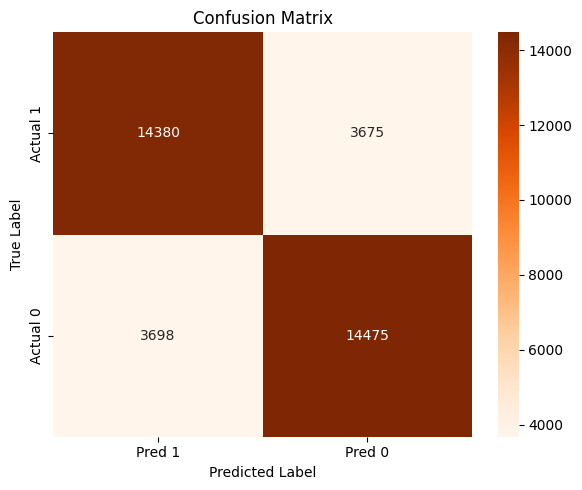

In [ ]:
#confusion matrix
cm = confusion_matrix(pdf_model["target"], pdf_model["prediction"], labels=[1, 0])

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Pred 1", "Pred 0"],
            yticklabels=["Actual 1", "Actual 0"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

ROC curve

computes and plots the ROC curve for the GBT classifier by extracting the probability of the positive class, calculating true/false positive rates, and displaying the AUC to visualize model discrimination performance.

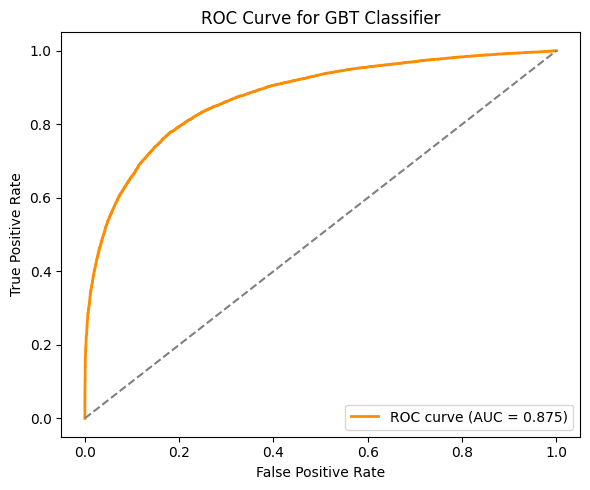

In [ ]:
pdf_model_roc = predictions.select("target", "prediction", "probability").toPandas()

# Extract class 1 probability from the vector
pdf_model_roc["prob_positive"] = pdf_model_roc["probability"].apply(lambda v: float(v[1]))
fpr, tpr, _ = roc_curve(pdf_model_roc["target"], pdf_model_roc["prob_positive"])
# roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(pdf_model_roc["target"], pdf_model_roc["prob_positive"]) # Use roc_auc_score instead of auc
# Plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for GBT Classifier")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()